Extracting /MNIST_data/train-images-idx3-ubyte.gz
Extracting /MNIST_data/train-labels-idx1-ubyte.gz
Extracting /MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /MNIST_data/t10k-labels-idx1-ubyte.gz
(?, 4, 4, 128)
(?, 28, 28, 1)
epoch 1 loss 0.03890856355428696
epoch 2 loss 0.03199116885662079
epoch 3 loss 0.027226891368627548
epoch 4 loss 0.02600179798901081
epoch 5 loss 0.02426101081073284
epoch 6 loss 0.023831570520997047
epoch 7 loss 0.02237270213663578
epoch 8 loss 0.023688089102506638
epoch 9 loss 0.021605854853987694
epoch 10 loss 0.020856015384197235
epoch 11 loss 0.02077528089284897
epoch 12 loss 0.019754571840167046
epoch 13 loss 0.019218089058995247
epoch 14 loss 0.019719138741493225
epoch 15 loss 0.020082393661141396
epoch 16 loss 0.020060699433088303
epoch 17 loss 0.01929783821105957
epoch 18 loss 0.019251082092523575
epoch 19 loss 0.020197296515107155
epoch 20 loss 0.018641257658600807


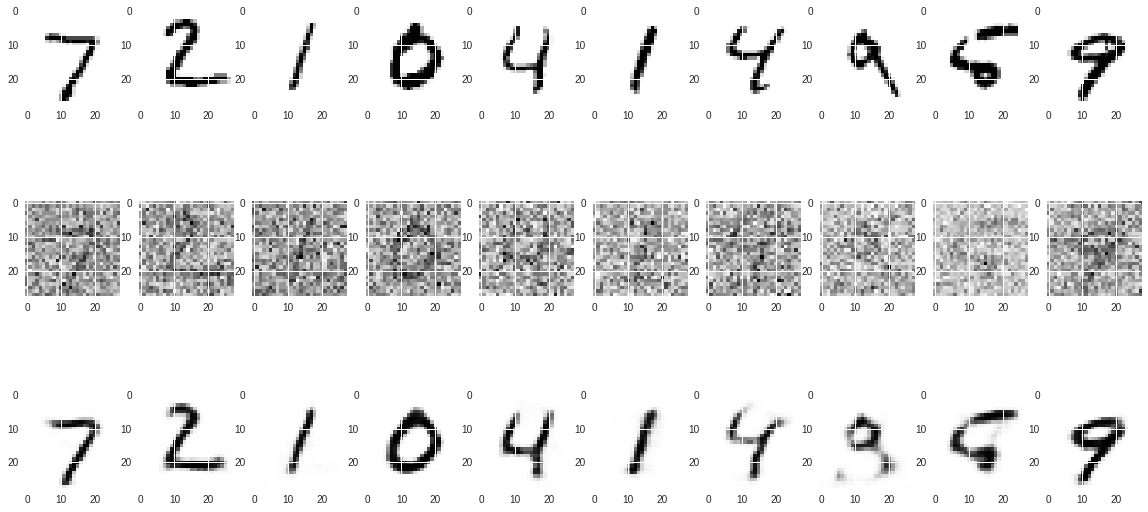

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import fully_connected
import cv2

mnist = input_data.read_data_sets("/MNIST_data/", one_hot=True)

x = tf.placeholder(tf.float32, shape = [None, 784])
X = tf.reshape(x, [-1, 28, 28, 1])
y = tf.placeholder(tf.float32, shape = [None, 784])
Y = tf.reshape(y, [-1, 28, 28, 1])

initializer = tf.contrib.layers.variance_scaling_initializer()
#kernels
ew1 = tf.Variable(initializer([3,3,1,32]), dtype = tf.float32)
ew2 = tf.Variable(initializer([3,3,32,64]), dtype = tf.float32)
ew3 = tf.Variable(initializer([3,3,64,128]), dtype = tf.float32)

dw1 = tf.Variable(initializer([3,3,128,64]), dtype = tf.float32)
dw2 = tf.Variable(initializer([3,3,64,32]), dtype = tf.float32)
dw3 = tf.Variable(initializer([3,3,32,16]), dtype = tf.float32)

dw = tf.Variable(initializer([3,3,16,1]), dtype = tf.float32)

#biases
eb1 = tf.Variable(tf.zeros(32))
eb2 = tf.Variable(tf.zeros(64))
eb3 = tf.Variable(tf.zeros(128))

db1 = tf.Variable(tf.zeros(64))
db2 = tf.Variable(tf.zeros(32))
db3 = tf.Variable(tf.zeros(16))

db = tf.Variable(tf.zeros(1))

strides = 1 #convolution
k = 2 #pooling

#model

conv1 = tf.nn.conv2d(X, ew1, strides = [1, strides, strides, 1], padding = 'SAME')
conv1 = tf.nn.bias_add(conv1, eb1)
conv1 = tf.nn.leaky_relu(conv1)
conv1 = tf.nn.max_pool(conv1, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding= 'SAME')

conv2 = tf.nn.conv2d(conv1, ew2, strides = [1, strides, strides, 1], padding = 'SAME')
conv2 = tf.nn.bias_add(conv2, eb2)
conv2 = tf.nn.leaky_relu(conv2)
conv2 = tf.nn.max_pool(conv2, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding= 'SAME')

conv3 = tf.nn.conv2d(conv2, ew3, strides = [1, strides, strides, 1], padding = 'SAME')
conv3 = tf.nn.bias_add(conv3, eb3)
conv3 = tf.nn.leaky_relu(conv3)
encoder = tf.nn.max_pool(conv3, ksize = [1, k, k, 1], strides = [1, k, k, 1], padding= 'SAME')
print(encoder.get_shape())

upsample1 = tf.image.resize_images(encoder, size = (7,7), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
conv4 = tf.nn.conv2d(upsample1, dw1, strides = [1, strides, strides, 1], padding = 'SAME')
conv4 = tf.nn.bias_add(conv4, db1)
conv4 = tf.nn.leaky_relu(conv4)

upsample2 = tf.image.resize_images(conv4, size = (14,14), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
conv5 = tf.nn.conv2d(upsample2, dw2, strides = [1, strides, strides, 1], padding = 'SAME')
conv5 = tf.nn.bias_add(conv5, db2)
conv5 = tf.nn.leaky_relu(conv5)

upsample3 = tf.image.resize_images(conv5, size = (28,28), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
conv6 = tf.nn.conv2d(upsample3, dw3, strides = [1, strides, strides, 1], padding = 'SAME')
conv6 = tf.nn.bias_add(conv6, db3)
conv6 = tf.nn.leaky_relu(conv6)

decoder = tf.nn.conv2d(conv6, dw, strides = [1, strides, strides, 1], padding = 'SAME')
decoder = tf.nn.bias_add(decoder, db)
decoder = tf.nn.sigmoid(decoder)
print(decoder.get_shape())

with tf.device('/gpu:0'): 
    lr = 0.0001
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = x, logits = oned))
    loss = tf.reduce_mean(tf.square(decoder - Y))
    optimizer = tf.train.AdamOptimizer(lr)
    train = optimizer.minimize(loss)
    init = tf.global_variables_initializer()

num_epoch = 20
batch_size = 150
num_test_images = 10

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        num_batches = mnist.train.num_examples // batch_size
        for i in range(num_batches):
            X_batch,_ = mnist.train.next_batch(batch_size)
            #noise_factor = 0.5
            noised_batch = X_batch + 0.7*np.random.randn(*X_batch.shape)
            sess.run(train, feed_dict={x:noised_batch, y:X_batch})
        train_loss = loss.eval(feed_dict = {x:noised_batch, y:X_batch})
        print("epoch {} loss {}".format(epoch+1, train_loss))
    noise_test = mnist.test.images + 0.7*np.random.randn(*mnist.test.images.shape)
    results = decoder.eval(feed_dict={x:noise_test,y:mnist.test.images[:num_test_images]})
    f,a=plt.subplots(3,10,figsize=(20,10))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(noise_test[i],(28,28)))
        a[2][i].imshow(np.reshape(results[i],(28,28)))